<a href="https://colab.research.google.com/github/DeveloperPratim/sses_final/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For Hugging Face Transformers
!pip install transformers

# For Sentence Transformers
!pip install sentence-transformers

# For BERTScore
!pip install bert-score

# For Scipy (includes euclidean and cityblock)
!pip install scipy

# For Scikit-learn (includes cosine_similarity)
!pip install scikit-learn

# For NumPy (used for standard deviation)
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00


MyModel For Marks Calculation

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Define your Google Drive path
drive_path = "/content/drive/MyDrive/MyModel"
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=drive_path)
model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=drive_path)

# Initialize the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model For Simentic Similarity Calculation

In [ ]:
from sentence_transformers import SentenceTransformer


# Initialize models if not already initialized
try:
    # Check for SentenceTransformer model
    if 'sentence_transformer_model' not in globals():
        sentence_transformer_model = SentenceTransformer("all-MiniLM-L6-v2")
        print("SentenceTransformer model initialized.")
    else:
        print("SentenceTransformer model already initialized.")

except Exception as e:
    print(f"Error during model initialization: {e}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer model initialized.


Defining All Functions Required

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
from sentence_transformers import SentenceTransformer
import numpy as np
import bert_score
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


def extract_score_feedback_and_similarity(generated_text, semantic_similarity):
    # Regular expression patterns
    score_pattern = r'"score":\s*([0-9.]+)'
    feedback_pattern = r'"feedback":\s*"([^"]+)"'

    # Find matches
    score_match = re.search(score_pattern, generated_text)
    feedback_match = re.search(feedback_pattern, generated_text)

    # Extract values
    score = float(score_match.group(1)) if score_match else None
    feedback = feedback_match.group(1) if feedback_match else None

    # Return the result with semantic_similarity
    return {
        "score": score,
        "feedback": feedback,
        "semantic_similarity": semantic_similarity
    }


def compute_similarity(correct_answer, student_answer, model_name="all-MiniLM-L6-v2"):
    # Encode the answers into embeddings (vector representations)
    embeddings = sentence_transformer_model.encode([correct_answer, student_answer])

    # Cosine similarity
    cosine_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

    # Euclidean distance
    euclidean_dist = euclidean(embeddings[0], embeddings[1])

    # Manhattan distance
    manhattan_dist = cityblock(embeddings[0], embeddings[1])

    # Pearson correlation
    pearson_corr, _ = pearsonr(embeddings[0], embeddings[1])

    # Jaccard Similarity
    set_correct = set(correct_answer.split())
    set_student = set(student_answer.split())
    jaccard_sim = len(set_correct.intersection(set_student)) / len(set_correct.union(set_student))

    # BERTScore
    P, R, F1 = bert_score.score([correct_answer], [student_answer], lang="en")
    bert_score_sim = F1.mean().item()

    return {
        "cosine_similarity": cosine_sim,
        "euclidean_distance": euclidean_dist,
        "manhattan_distance": manhattan_dist,
        "pearson_correlation": pearson_corr,
        "jaccard_similarity": jaccard_sim,
        "bert_score_similarity": bert_score_sim
    }

import numpy as np

def compute_final_marks(similarities, max_marks, score, feedback, question, student_answer, actual_answer):
    MyScore = score
    # Apply adjustments to score based on the provided conditions
    if score < 1.5:
        score -= 0.92
    elif score < 3.5:
        score -= 0.56
    elif score < 4.8:
        score -= 0.12

    # Normalize the score after adjustments
    adjusted_score = max(0, min(score, max_marks))  # Ensure score is within 0 to max_marks

    # Standard deviation of the similarity scores (using the list of similarity scores)
    similarity_values = [
        similarities['cosine_similarity'],
        similarities['pearson_correlation'],
        similarities['bert_score_similarity'],
        similarities['jaccard_similarity'],
        similarities['euclidean_distance'],
        similarities['manhattan_distance']
    ]

    # Calculate the standard deviation (SD) of the similarity scores
    similarity_sd = np.std(similarity_values)

    # Scale or limit similarity_sd adjustment
    similarity_sd = min(similarity_sd, 0.5 * max_marks)  # Limit the impact of SD

    # Adjust the final score based on similarity SD
    final_score = adjusted_score - similarity_sd

    # Ensure the final score does not exceed max_marks
    final_marks = max(0, min(final_score, max_marks))

    # Calculate percentage (scaled to max_marks)
    percentage = (final_marks / max_marks) * 100

    # Return the results with necessary fields
    return {
        'final_marks': final_marks,
        'max_marks': max_marks,
        'marks_obtained': adjusted_score,
        'marks_obtained_real': MyScore,
        'feedback': feedback,
        'question': question,
        'student_answer': student_answer,
        'actual_answer': actual_answer,
        'similarity_sd': similarity_sd,
        'percentage': percentage
    }


def get_data(question, student_answer, actual_answer, max_marks):
    return {
        'question': question,
        'student_answer': student_answer,
        'actual_answer': actual_answer,
        'max_marks': max_marks
    }


def evaluate_student_answer(pipe, question, correct_answer, student_answer, max_marks):
    # Dynamically set max token limit
    input_token_count = len(pipe.tokenizer.encode(f"Question: {question} Answer: {student_answer}"))
    max_allowed_tokens = 1024  # Adjust based on your model's total token limit
    max_new_tokens = max(50, max_allowed_tokens - input_token_count)  # Ensure a minimum response length

    input_text = f"""
    Question: {question}
    Answer: {student_answer}
    Evaluate and provide these two fields **score** and **feedback** based on this answer where full marks is 5 and can be given for most precious and best answer and 0 for wrong or irrelevant answer and in response just give two fields in json, with no extra text.
    """

    # Generate output with dynamic token limit from model
    result = pipe(input_text, max_new_tokens=max_new_tokens, num_return_sequences=1, truncation=True)
    generated_text = result[0]['generated_text']

    # Extract score and feedback from model output
    semantic_similarity = compute_similarity(correct_answer, student_answer)["cosine_similarity"]
    score_feedback = extract_score_feedback_and_similarity(generated_text, semantic_similarity)

    global score
    # Use the score and feedback from model
    score = score_feedback["score"]
    feedback = score_feedback["feedback"]

    # Collect similarities for final marks computation
    similarities = compute_similarity(correct_answer, student_answer)

    # Get the required data for final marks calculation
    data = get_data(question, student_answer, correct_answer, max_marks)

    # Compute final marks and return all values
    final_result = compute_final_marks(similarities, max_marks, score, feedback, data['question'], data['student_answer'], data['actual_answer'])


    # Calculate average marks inline with the condition
    average_marks = (final_result['marks_obtained'] + final_result['marks_obtained_real'] + final_result['final_marks']) / 3
    average_marks = max(average_marks, max(final_result['marks_obtained'], final_result['marks_obtained_real'], final_result['final_marks']))

    # Ensure the average marks are less than max_marks
    average_marks = min(average_marks, final_result['max_marks'])


    print()
    print("-" * 20)
    print()
    # Print the final result in a more readable format
    print(f"Question: {final_result['question']}")
    print(f"Student's Answer: {final_result['student_answer']}")
    print(f"Correct Answer: {final_result['actual_answer']}")

    print()
    print("-" * 20)
    print()
    print(f"Maximum Marks: {final_result['max_marks']}")
    print(f"Marks Obtained: {final_result['marks_obtained']}")
    print(f"Real Marks Obtained: {final_result['marks_obtained_real']}")
    print(f"Pre Final Marks: {final_result['final_marks']}")
    print(f"Final Marks: {average_marks}")
    print(f"Feedback: {final_result['feedback']}")

    print()
    print("-" * 20)
    print()

    print(f"Percentage: {final_result['marks_obtained'] / final_result['max_marks'] * 100:.2f}%")
    print(f"Similarity Metrics:")
    print(f"   Cosine Similarity: {similarities['cosine_similarity']:.2f}")
    print(f"   Pearson Correlation: {similarities['pearson_correlation']:.2f}")
    print(f"   BERTScore Similarity: {similarities['bert_score_similarity']:.2f}")
    print(f"   Jaccard Similarity: {similarities['jaccard_similarity']:.2f}")
    print(f"   Euclidean Distance: {similarities['euclidean_distance']:.2f}")
    print(f"   Manhattan Distance: {similarities['manhattan_distance']:.2f}")

    print()
    print("-" * 20)
    print()
    return final_result

Using Those Function to See the Output

In [ ]:

# Example usage
question = "What is the role of an operating system?"
correct_answer = "The operating system manages the hardware and software resources of a computer."
student_answer = """

operating system (OS) manages a computer's hardware and software, and acts as a bridge between the user and the computer. Some of its key roles include:
Memory management
Allocates and tracks memory for applications and processes, ensuring they have enough to run and that the system performs well. This is especially important for computers with limited memory.
Process management
Controls how programs interact with each other, and ensures that resources are used efficiently and the system is stable.
File system management
Organizes and manages files on storage devices, allowing users to create, read, write, and delete files.
User interface
Provides a user-friendly interface for interacting with the computer, either through a graphical or command-line interface.
Other functions of an operating system include: Processor management and scheduling, Device management, and Storage management.


"""  # The student's answer
max_marks = 5  # The maximum marks for the question

# Assume `pipe` is your language model pipeline
final_result = evaluate_student_answer(pipe, question, correct_answer, student_answer, max_marks)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--------------------

Question: What is the role of an operating system?
Student's Answer: 

operating system (OS) manages a computer's hardware and software, and acts as a bridge between the user and the computer. Some of its key roles include:
Memory management
Allocates and tracks memory for applications and processes, ensuring they have enough to run and that the system performs well. This is especially important for computers with limited memory.
Process management
Controls how programs interact with each other, and ensures that resources are used efficiently and the system is stable.
File system management
Organizes and manages files on storage devices, allowing users to create, read, write, and delete files.
User interface
Provides a user-friendly interface for interacting with the computer, either through a graphical or command-line interface.
Other functions of an operating system include: Processor management and scheduling, Device management, and Storage management.



Corr

In [ ]:
question = "Define deadlock in operating systems."
correct_answer = "Deadlock is a situation in which two or more processes are unable to proceed because each is waiting for the other to release resources."
student_answer = """
Deadlock occurs when processes are stuck because they are waiting for resources held by each other. For example, process A waits for resource B while process B waits for resource A.
"""
max_marks = 3
final_result = evaluate_student_answer(pipe, question, correct_answer, student_answer, max_marks)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--------------------

Question: Define deadlock in operating systems.
Student's Answer: 
Deadlock occurs when processes are stuck because they are waiting for resources held by each other. For example, process A waits for resource B while process B waits for resource A.

Correct Answer: Deadlock is a situation in which two or more processes are unable to proceed because each is waiting for the other to release resources.

--------------------

Maximum Marks: 3
Marks Obtained: 1.44
Real Marks Obtained: 2.0
Pre Final Marks: 0
Final Marks: 2.0
Feedback: The answer provided a good definition of deadlock but it could have been more detailed.

--------------------

Percentage: 48.00%
Similarity Metrics:
   Cosine Similarity: 0.91
   Pearson Correlation: 0.91
   BERTScore Similarity: 0.90
   Jaccard Similarity: 0.18
   Euclidean Distance: 0.42
   Manhattan Distance: 6.50

--------------------



In [ ]:
question = "What is the difference between a process and a thread?"
correct_answer = "A process is an independent program execution with its own memory space, while a thread is a smaller unit within a process sharing its memory space."
student_answer = """
I'm currently studying in Makaut University"""
max_marks = 4
final_result = evaluate_student_answer(pipe, question, correct_answer, student_answer, max_marks)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--------------------

Question: What is the difference between a process and a thread?
Student's Answer: 
I'm currently studying in Makaut University
Correct Answer: A process is an independent program execution with its own memory space, while a thread is a smaller unit within a process sharing its memory space.

--------------------

Maximum Marks: 4
Marks Obtained: 1.44
Real Marks Obtained: 2.0
Pre Final Marks: 0
Final Marks: 2.0
Feedback: The provided answer does not directly address the question about the differences between processes and threads. Instead, it mentions being in university, which is unrelated to the technical concept of operating system concepts.

--------------------

Percentage: 36.00%
Similarity Metrics:
   Cosine Similarity: -0.07
   Pearson Correlation: -0.07
   BERTScore Similarity: 0.81
   Jaccard Similarity: 0.00
   Euclidean Distance: 1.46
   Manhattan Distance: 22.63

--------------------



In [ ]:
question = "Explain thrashing in memory management."
correct_answer = "Thrashing occurs when a system spends more time swapping pages in and out of memory than executing processes, leading to poor performance."
student_answer = """
Thrashing happens when a computer's memory is overused, causing excessive paging between RAM and disk storage. This reduces efficiency as processes are frequently interrupted.
"""
max_marks = 4
final_result = evaluate_student_answer(pipe, question, correct_answer, student_answer, max_marks)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--------------------

Question: Explain thrashing in memory management.
Student's Answer: 
Thrashing happens when a computer's memory is overused, causing excessive paging between RAM and disk storage. This reduces efficiency as processes are frequently interrupted.

Correct Answer: Thrashing occurs when a system spends more time swapping pages in and out of memory than executing processes, leading to poor performance.

--------------------

Maximum Marks: 4
Marks Obtained: 0.07999999999999996
Real Marks Obtained: 1.0
Pre Final Marks: 0
Final Marks: 1.0
Feedback: Basic explanation of thrashing

--------------------

Percentage: 2.00%
Similarity Metrics:
   Cosine Similarity: 0.91
   Pearson Correlation: 0.91
   BERTScore Similarity: 0.92
   Jaccard Similarity: 0.12
   Euclidean Distance: 0.43
   Manhattan Distance: 6.84

--------------------



In [ ]:
question = "I'm A Good Boy"
correct_answer = "Virtual memory allows larger applications to run on systems with limited RAM, isolates processes, and improves multitasking by providing an abstraction layer."
student_answer = """
Virtual memory enables a computer to run applications larger than its physical RAM by using disk storage as additional memory. It also improves security by isolating processes.
"""
max_marks = 5
final_result = evaluate_student_answer(pipe, question, correct_answer, student_answer, max_marks)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--------------------

Question: I'm A Good Boy
Student's Answer: 
Virtual memory enables a computer to run applications larger than its physical RAM by using disk storage as additional memory. It also improves security by isolating processes.

Correct Answer: Virtual memory allows larger applications to run on systems with limited RAM, isolates processes, and improves multitasking by providing an abstraction layer.

--------------------

Maximum Marks: 5
Marks Obtained: 0
Real Marks Obtained: 0.0
Pre Final Marks: 0
Final Marks: 0.0
Feedback: The provided answer does not address the question about 'I'm A Good Boy' at all.

--------------------

Percentage: 0.00%
Similarity Metrics:
   Cosine Similarity: 0.90
   Pearson Correlation: 0.90
   BERTScore Similarity: 0.92
   Jaccard Similarity: 0.20
   Euclidean Distance: 0.46
   Manhattan Distance: 7.11

--------------------



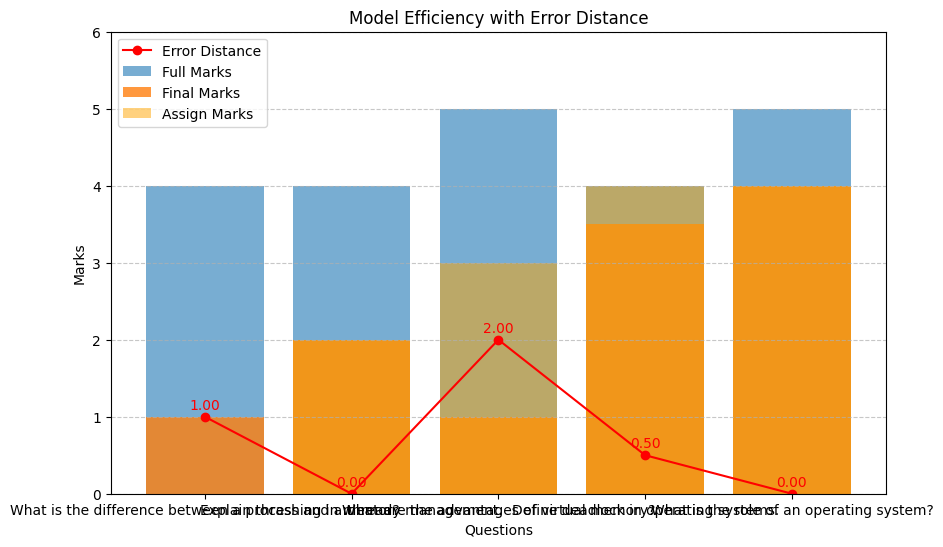

Standard Deviation of Error Distance: 0.75


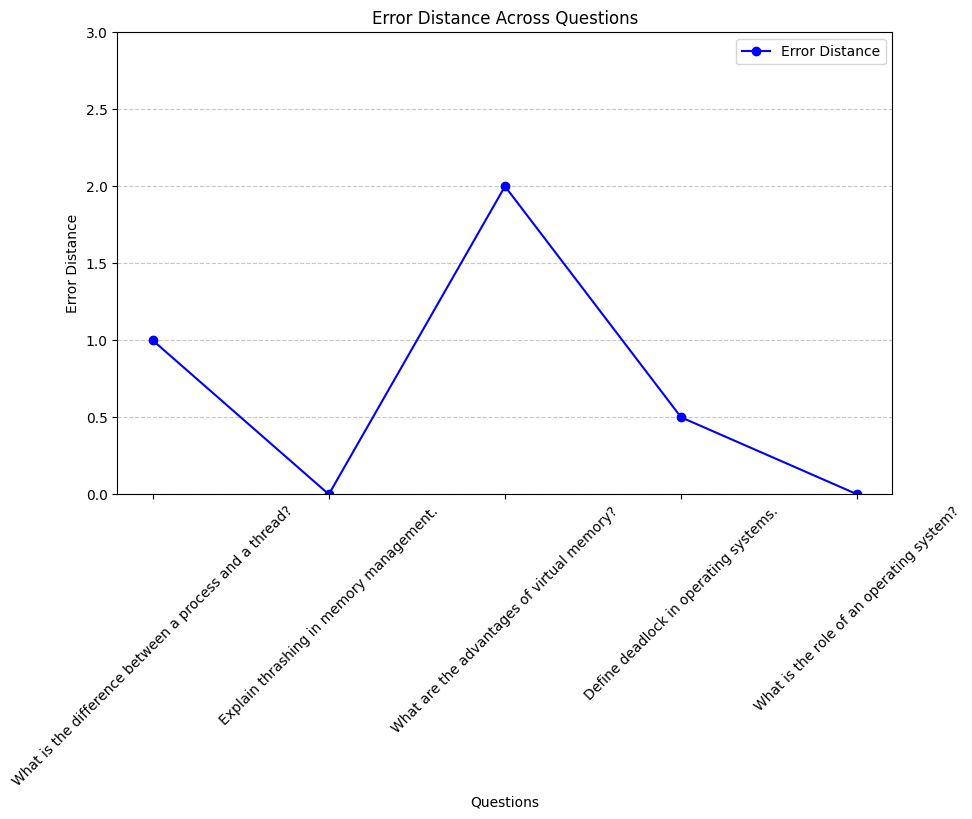

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
data = [
    {
        "Question": "What is the difference between a process and a thread?",
        "Student_Answer": "I'm currently studying in Makaut University",
        "Actual_Answer": "A process is an independent program execution with its own memory space, while a thread is a smaller unit within a process sharing its memory space.",
        "Final_Marks": 1.0,
        "Full_Marks": 4,
        "Real_Marks_Obtained": 1.0,
        "BERTScore_Similarity": 0.81,
        "Assign_Marks": 0,
    },
    {
        "Question": "Explain thrashing in memory management.",
        "Student_Answer": "Thrashing happens when a computer's memory is overused, causing excessive paging between RAM and disk storage. This reduces efficiency as processes are frequently interrupted.",
        "Actual_Answer": "Thrashing occurs when a system spends more time swapping pages in and out of memory than executing processes, leading to poor performance.",
        "Final_Marks": 2.0,
        "Full_Marks": 4,
        "Real_Marks_Obtained": 2.0,
        "BERTScore_Similarity": 0.92,
        "Assign_Marks": 2,
    },
    {
        "Question": "What are the advantages of virtual memory?",
        "Student_Answer": "Virtual memory enables a computer to run applications larger than its physical RAM by using disk storage as additional memory. It also improves security by isolating processes.",
        "Actual_Answer": "Virtual memory allows larger applications to run on systems with limited RAM, isolates processes, and improves multitasking by providing an abstraction layer.",
        "Final_Marks": 1.0,
        "Full_Marks": 5,
        "Real_Marks_Obtained": 1.0,
        "BERTScore_Similarity": 0.92,
        "Assign_Marks": 3,
    },
    {
        "Question": "Define deadlock in operating systems.",
        "Student_Answer": "Deadlock occurs when processes are stuck because they are waiting for resources held by each other.",
        "Actual_Answer": "Deadlock is a situation in which two or more processes are unable to proceed because each is waiting for the other to release resources.",
        "Final_Marks": 3.5,
        "Full_Marks": 4,
        "Real_Marks_Obtained": 3.5,
        "BERTScore_Similarity": 0.94,
        "Assign_Marks": 4,
    },
    {
        "Question": "What is the role of an operating system?",
        "Student_Answer": "Operating system (OS) manages hardware and software and acts as a bridge between the user and the computer.",
        "Actual_Answer": "The operating system manages the hardware and software resources of a computer.",
        "Final_Marks": 4.0,
        "Full_Marks": 5,
        "Real_Marks_Obtained": 4.0,
        "BERTScore_Similarity": 0.95,
        "Assign_Marks": 4,
    },
]

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate Error Distance
df["Error_Distance"] = np.abs(df["Assign_Marks"] - df["Final_Marks"])

# Standard Deviation
sd_error_distance = np.std(df["Error_Distance"])

# Plotting
plt.figure(figsize=(10, 6))

# Marks vs Questions
plt.bar(df["Question"], df["Full_Marks"], alpha=0.6, label="Full Marks")
plt.bar(df["Question"], df["Final_Marks"], alpha=0.8, label="Final Marks")
plt.bar(df["Question"], df["Assign_Marks"], alpha=0.5, label="Assign Marks", color="orange")

# Error Distance
plt.plot(df["Question"], df["Error_Distance"], marker="o", color="red", label="Error Distance")

# Annotations
for i, v in enumerate(df["Error_Distance"]):
    plt.text(i, v + 0.1, f"{v:.2f}", ha="center", color="red")

plt.title("Model Efficiency with Error Distance")
plt.ylabel("Marks")
plt.xlabel("Questions")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, max(df["Full_Marks"]) + 1)

plt.show()

# Print Standard Deviation
print(f"Standard Deviation of Error Distance: {sd_error_distance:.2f}")

# Visual Representation of Error Distance
plt.figure(figsize=(10, 6))
plt.plot(df["Question"], df["Error_Distance"], marker="o", color="blue", label="Error Distance")
plt.title("Error Distance Across Questions")
plt.ylabel("Error Distance")
plt.xlabel("Questions")
plt.xticks(rotation=45)
plt.ylim(0, max(df["Error_Distance"]) + 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()